In [ ]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import math

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from skorch import NeuralNet
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

In [ ]:
players = pd.read_csv("drive/MyDrive/Colab Notebooks/ai_project/artificial_project/players.csv", encoding="latin-1", delimiter=";")

del players["Rk"]
players["Player"] = players["Player"].str.replace("*","", regex=False)
players = players[players['Player'] != 'Player']
players = players.apply(pd.to_numeric, errors='ignore')

In [ ]:
teams = pd.read_csv("drive/MyDrive/Colab Notebooks/ai_project/artificial_project/teams.csv", encoding="latin-1", delimiter=";")
teams = teams[~teams["W"].str.contains("Division")].copy()
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)

In [ ]:
nicknames = {}
with open("drive/MyDrive/Colab Notebooks/ai_project/artificial_project/nicknames.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev,name = line.replace("\n","").split(";")
        nicknames[abbrev] = name

In [ ]:
players["Team"] = players["Tm"].map(nicknames)
players = players.merge(teams, how="outer",on=["Team", "Year"])

players = players[players['Tm'] != "TOT"]

In [ ]:
players.head(1)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.474,0.0,0.0,0.0,1.3,2.7,0.474,0.474,0.6,1.0,0.568,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991,Portland Trail Blazers,63,19,0.768,,114.7,106,8.47


#Data Featuring

In [ ]:
featured_players = players.copy()

In [ ]:
featured_list = ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
featured_players = featured_players[featured_players['G'] >= 30]
featured_players = featured_players[featured_players['MP'] >= 10]
featured_players[featured_list] = featured_players[featured_list].mul(48, axis=0).div(featured_players['MP'], axis=0)

In [ ]:
featured_players.shape

(10026, 38)

In [ ]:
feature_info = ["Age", "FG", "FGA", 'FG%', "3P", "3PA", '3P%', "2P", "2PA", '2P%', "FT", "FTA", 'FT%', "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF"]

In [ ]:
Back_players = featured_players[(featured_players['Pos'] == 'C') | (featured_players['Pos'] == 'PF') | (featured_players['Pos'] == 'SF')]
Front_players = featured_players[(featured_players['Pos'] == 'SG') | (featured_players['Pos'] == 'PG')]

In [ ]:
Back_featured = Back_players[feature_info]
Front_featured = Front_players[feature_info]

scaler = MinMaxScaler()
Back_featured_normalized = scaler.fit_transform(Back_featured)
Back_featured = pd.DataFrame(Back_featured_normalized, columns=Back_featured.columns)
Front_featured_normalized = scaler.fit_transform(Front_featured)
Front_featured = pd.DataFrame(Front_featured_normalized, columns=Front_featured.columns)

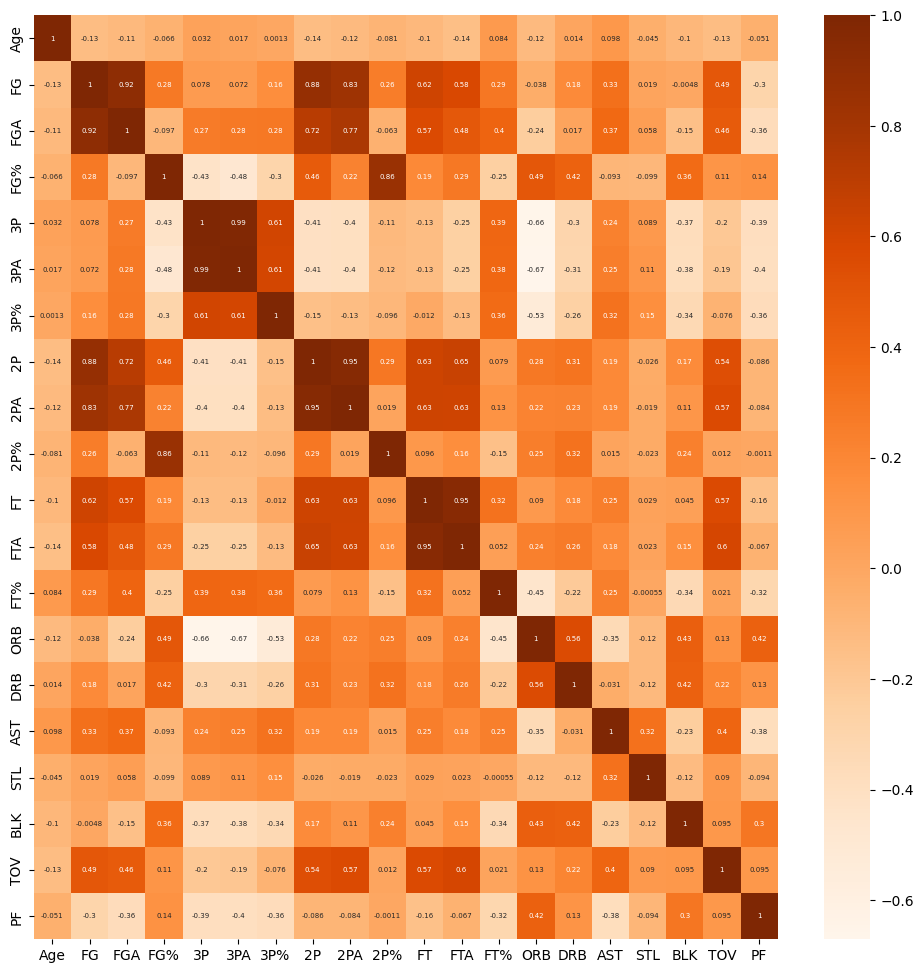

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(Back_featured.corr(), annot = True, cmap='Oranges', annot_kws={'size': 5}) 
plt.show()

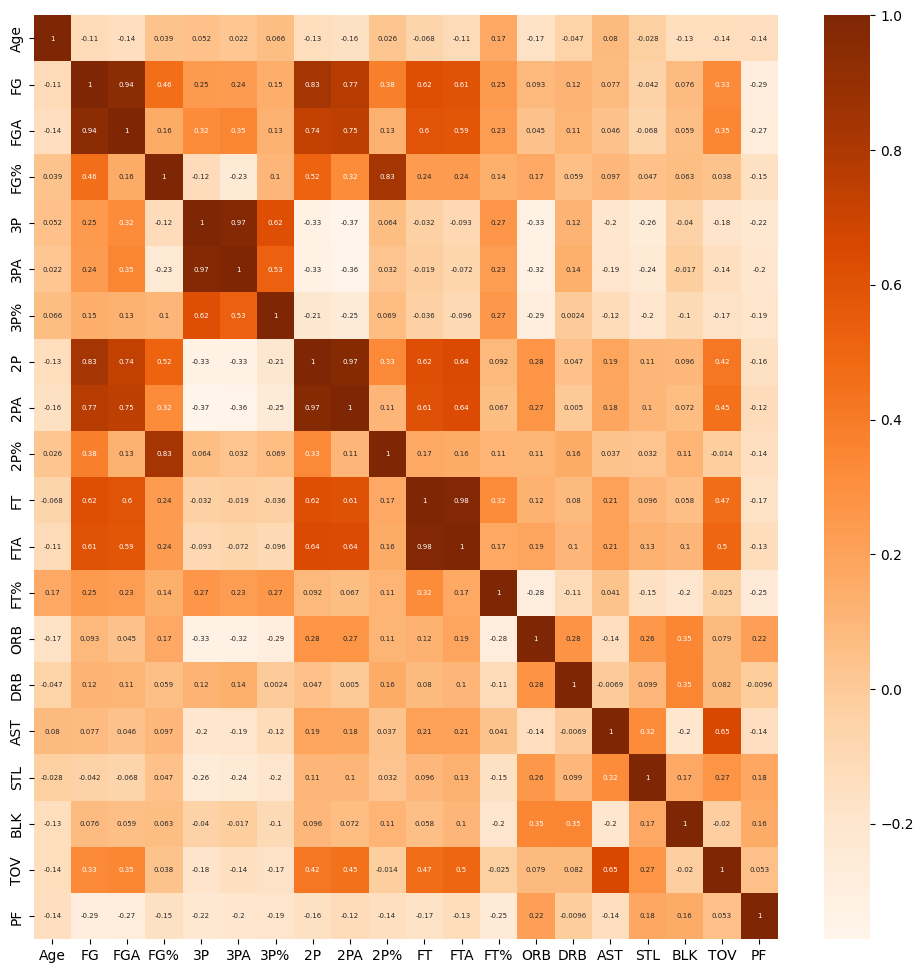

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(Front_featured.corr(), annot = True, cmap='Oranges', annot_kws={'size': 5}) 
plt.show()

In [ ]:
feature_info = ["Age", "FGA", 'FG%', "3PA", '3P%', "2PA", '2P%', "FTA", 'FT%', "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF"]

In [ ]:
Back_players = featured_players[(featured_players['Pos'] == 'C') | (featured_players['Pos'] == 'PF') | (featured_players['Pos'] == 'SF')].reset_index(drop=True)
Front_players = featured_players[(featured_players['Pos'] == 'SG') | (featured_players['Pos'] == 'PG')].reset_index(drop=True)

In [ ]:
Back_featured = Back_players[feature_info]
Front_featured = Front_players[feature_info]

scaler = MinMaxScaler()
Back_featured_normalized = scaler.fit_transform(Back_featured)
Back_featured = pd.DataFrame(Back_featured_normalized, columns=Back_featured.columns)
Front_featured_normalized = scaler.fit_transform(Front_featured)
Front_featured = pd.DataFrame(Front_featured_normalized, columns=Front_featured.columns)

In [ ]:
Back_featured['MP'] = Back_players['MP']
Back_featured['Tm'] = Back_players['Tm']
Back_featured['Year'] = Back_players['Year']
Back_featured['W/L%'] = Back_players['W/L%']

Front_featured['MP'] = Front_players['MP']
Front_featured['Tm'] = Front_players['Tm']
Front_featured['Year'] = Front_players['Year']
Front_featured['W/L%'] = Front_players['W/L%']

#Dataset

In [ ]:
merged_players = pd.concat([Front_featured, Back_featured], axis=0)
merged_players = merged_players.sort_values('MP', ascending=False)

In [ ]:
merged_players = np.array(merged_players)
merged_players.shape

(10026, 20)

In [ ]:
merged_players[0]

array([0.3333333333333335, 0.899503492178963, 0.38926174496644317,
       0.27730229373502235, 0.4362818590704647, 0.8749944973513916,
       0.41715399610136444, 0.6886846603496696, 0.7851428571428571,
       0.171195652173913, 0.2520995100483618, 0.3030432045233093,
       0.5209585320473062, 0.08321198252548367, 0.5489687989794255,
       0.0959924895851669, 43.7, 'PHI', 2002, '0.524'], dtype=object)

In [ ]:
team_list = ['ATL', 'BOS', 'BRK', 'CHA', 'CHH', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL',
 'MIN', 'NJN', 'NOH', 'NOK', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'SEA', 'TOR', 'TOT', 'UTA', 'VAN', 'WAS', 'WSB']

year_list = []
for i in range(31):
  year_list.append(1991 + i)

In [ ]:
X = []
Y = []

for i in team_list:
  for j in year_list:
    X_year = []
    Y_year = -1.0
    for k in range(len(merged_players)):
      if merged_players[k][17] == i and merged_players[k][18] == j and len(X_year) < 160:
        for l in range(16):
          X_year.append(merged_players[k][l])  
        Y_year = float(merged_players[k][19])

    if not Y_year == -1.0 and len(X_year) == 160:
      X.append(X_year)
      Y.append(Y_year)

X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)
Y = Y.reshape(-1, 1)

In [ ]:
print(X.shape)
print(Y.shape)

(803, 160)
(803, 1)


#Training

In [ ]:
datasets = np.hstack((X, Y))
np.random.shuffle(datasets)

In [ ]:
datasets.shape

(803, 161)

In [ ]:
datasets_X = torch.FloatTensor(datasets[:, :-1])
datasets_y = torch.FloatTensor(datasets[:, -1]).reshape(-1, 1)

In [ ]:
split_index = int(0.8 * datasets.shape[0])
trainset = datasets[:split_index]
testset = datasets[split_index:]

In [ ]:
print(trainset.shape)
print(testset.shape)

(642, 161)
(161, 161)


In [ ]:
trainset_X = torch.FloatTensor(trainset[:, :-1])
trainset_y = torch.FloatTensor(trainset[:, -1]).reshape(-1, 1)

testset_X = torch.FloatTensor(testset[:, :-1])
testset_y = torch.FloatTensor(testset[:, -1]).reshape(-1, 1)

In [ ]:
class Team_layer(torch.nn.Module):
  def __init__(self):
    super(Team_layer, self).__init__()
    self.MLP1 = torch.nn.Linear(160, 128)
    self.MLP2 = torch.nn.Linear(128, 64)
    self.MLP3 = torch.nn.Linear(64, 32)
    self.MLP4 = torch.nn.Linear(32, 1)

  def forward(self, x):
    y = self.MLP1(x)
    y = torch.nn.functional.relu(y)
    y = self.MLP2(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP3(y)
    y = torch.nn.functional.relu(y)
    y = self.MLP4(y)

    return y

In [ ]:
net = NeuralNet(Team_layer, 
                max_epochs = 100, 
                lr=0.002, 
                criterion=torch.nn.MSELoss, 
                optimizer=torch.optim.Adam, 
                verbose=0,
                device='cpu')

In [ ]:
params = {'lr':[0.001, 0.005, 0.01],
          'max_epochs':[50, 100, 150, 200]}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

In [ ]:
gs = GridSearchCV(estimator=net, 
                  param_grid=params,
                  scoring=scoring, 
                  cv=5, 
                  verbose=0)

gs.fit(trainset_X, trainset_y)
print(f'MSE: {-gs.best_score_ :.4f}')
print(gs.best_params_)

MSE: 0.0125
{'lr': 0.005, 'max_epochs': 100}


In [ ]:
X_df = torch.FloatTensor(trainset_X)
y_df= torch.FloatTensor(trainset_y).reshape(-1, 1)

Fold 1


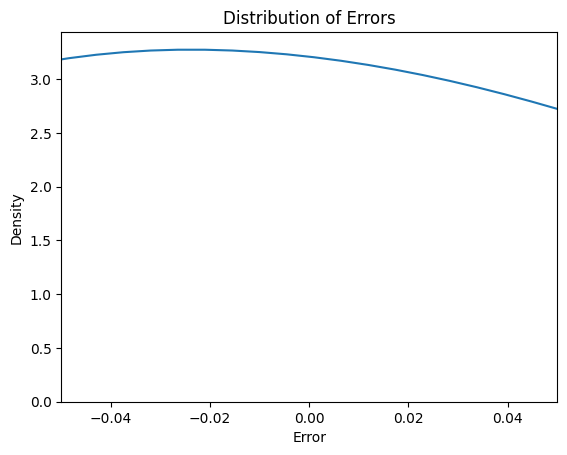

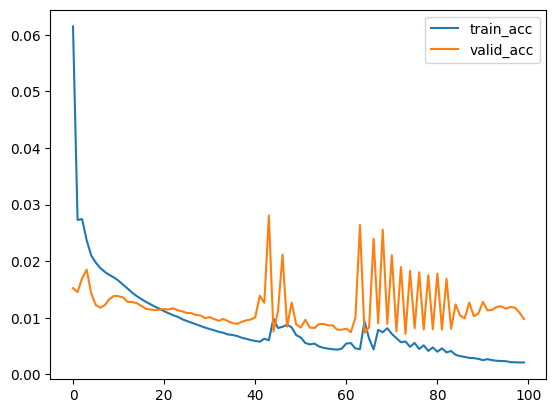

Fold 2


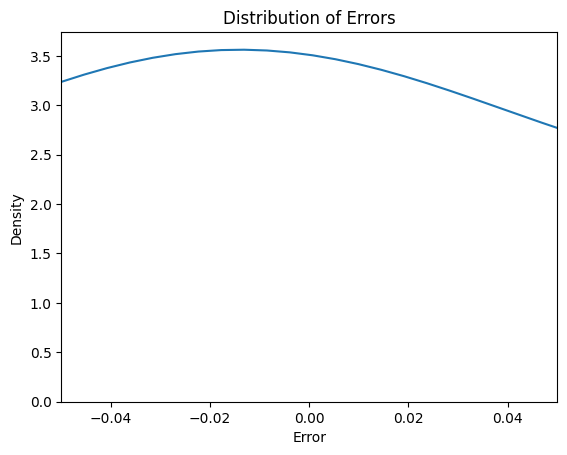

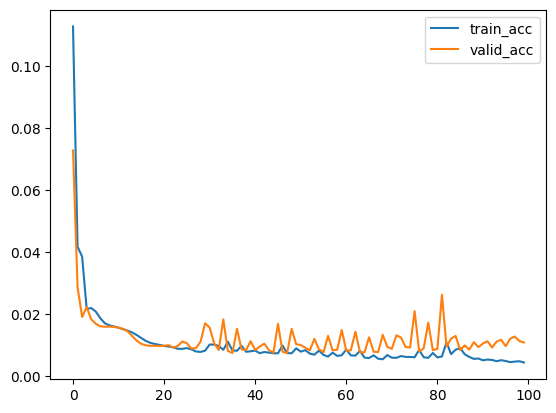

Fold 3


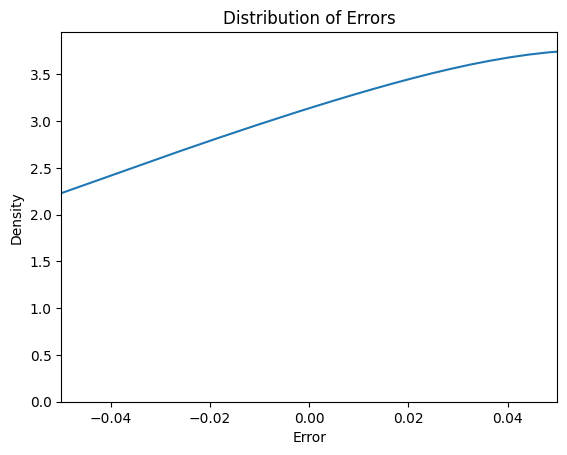

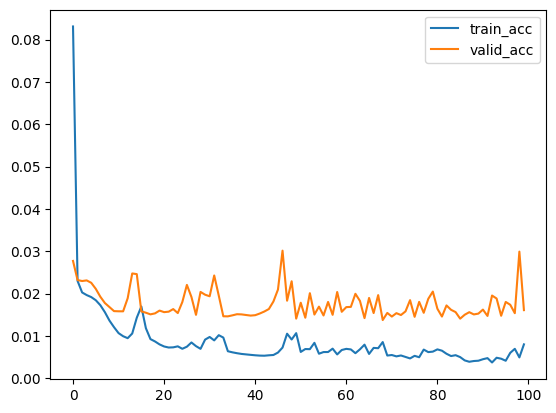

Fold 4


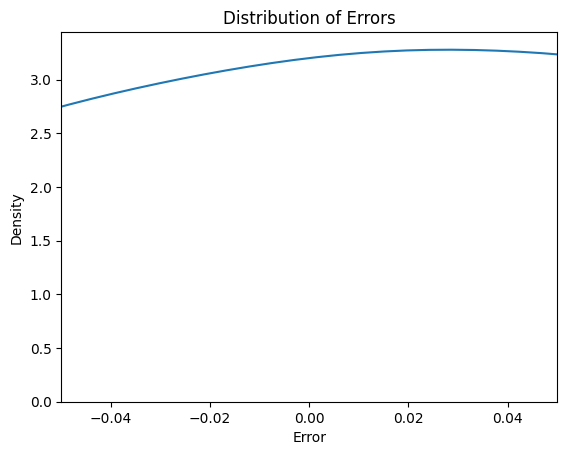

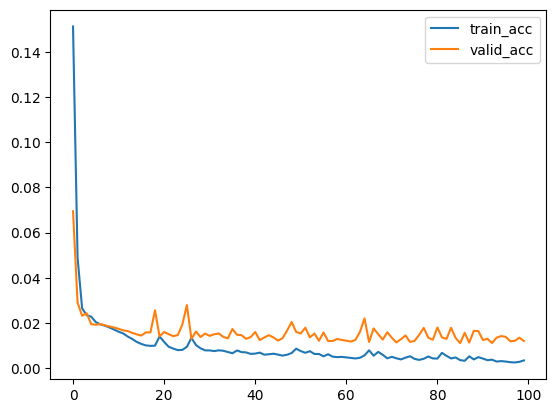

Fold 5


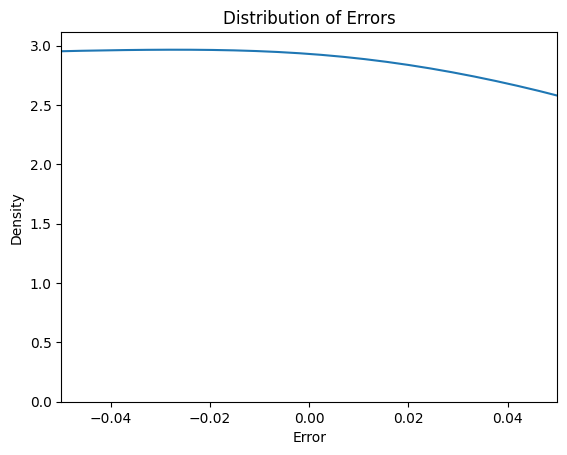

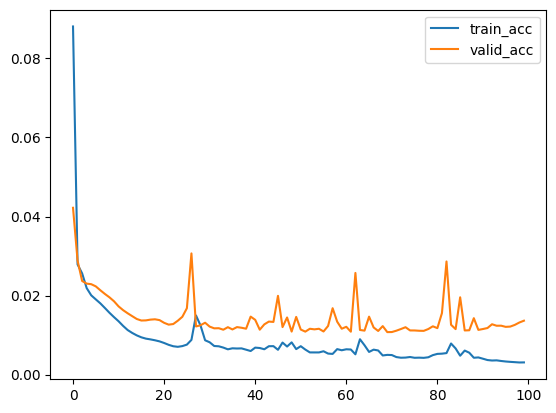

Average percentage of test data with a prediction error of less than 5%.: 27.9503%
Average MSE of train dataset: 0.0031
Average MSE of valid dataset: 0.0136


In [ ]:
optimal_epochs = 100
optimal_lr = 0.005

import seaborn as sns


kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx,val_idx) in enumerate(kf.split(range(len(X_df)))):

  print('Fold {}'.format(fold + 1))
  train_X = X_df[train_idx]
  train_Y = y_df[train_idx]
  valid_X = X_df[val_idx]
  valid_Y = y_df[val_idx]
  train_dataset = TensorDataset(train_X, train_Y)
  valid_dataset = TensorDataset(valid_X, valid_Y)
  train_dataloader = DataLoader(train_dataset, batch_size=64)
  valid_dataloader = DataLoader(valid_dataset, batch_size=64)

  model = Team_layer()
  loss_func = torch.nn.MSELoss()
  optim = torch.optim.Adam(model.parameters(), lr = optimal_lr)

  history = {'percent_5%':[],'train_acc':[],'valid_acc':[]}
    
  train_acc_lst = []
  valid_acc_lst = []

  for epoch in range(1, optimal_epochs+1):
    train_acc = 0
    train_total = 0
    valid_acc = 0
    valid_total = 0

    for i, data in enumerate(train_dataloader):
      x, target = data
      model.train()
      y = model(x)
      loss = loss_func(y, target)
      train_acc += loss
      train_total += 1
      optim.zero_grad()
      loss.backward()
      optim.step()

    for i, data in enumerate(valid_dataloader):
      x, target = data
      model.eval()
      with torch.no_grad():
        y = model(x)
        loss = loss_func(y, target)
        valid_acc += loss
        valid_total += 1
      
    train_acc_lst.append((train_acc/train_total).detach().numpy())
    valid_acc_lst.append((valid_acc/valid_total).detach().numpy())


  succ= 0
  model.eval()
  errors = []
  with torch.no_grad():
    y = model(testset_X)
  for i in range(len(testset_y)):
    error = testset_y[i] - y[i]
    errors.append(error.item())
  
    if ((testset_y[i].item() - y[i]) < 0.05) and ((testset_y[i].item() - y[i]) > -0.05):
      succ = succ + 1
  history['percent_5%'].append(float(succ) / float(len(testset_y)))

  
  sns.kdeplot(np.array(errors))
  plt.xlabel('Error')
  plt.ylabel('Density')
  plt.title('Distribution of Errors')
  plt.xlim(-0.05, 0.05)
  plt.show()

  plt.plot(np.arange(len(train_acc_lst)), train_acc_lst, label='train_acc')
  plt.plot(np.arange(len(valid_acc_lst)), valid_acc_lst, label='valid_acc')
  plt.legend()
  plt.show()

  history['train_acc'].append(train_acc_lst[-1])
  history['valid_acc'].append(valid_acc_lst[-1])


avg_percent_5 = np.mean(history['percent_5%'])
print(f'Average percentage of test data with a prediction error of less than 5%.: {avg_percent_5*100 :.4f}%')

avg_acc_train = np.mean(history['train_acc'])
avg_acc_valid = np.mean(history['valid_acc'])
print(f'Average MSE of train dataset: {avg_acc_train :.4f}')
print(f'Average MSE of valid dataset: {avg_acc_valid :.4f}')